In [1]:
# loo is not needed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, t, laplace
import seaborn as sns
import os, wget, shutil
#from rich import print
import warnings
warnings.filterwarnings("ignore")
from math import erf, fabs, sqrt
from numba import njit, prange

In [2]:
@njit
def std_UO(data):
    
    mean_ = np.mean(data)
    std_ = np.sqrt(np.sum((data - mean_) ** 2) / (len(data) - 1))
    
    return std_ 
    


@njit
def ttest_1samp_UO(a, popmean):
    
    n = len(a)
    df = n - 1
    sample_mean = np.mean(a)
    sample_std = np.sqrt(np.sum((a - sample_mean) ** 2) / (len(a) - 1))
    
    t = (sample_mean - popmean) / (sample_std / sqrt(n))
    p = 2 * (1 - 0.5 * (1 + erf(fabs(t) / sqrt(2))))
    
    return t, p

@njit
def dp_(clean_data, pipeline_output):
    n = clean_data.size
    loo_output = np.empty(n)
    
    for i in range(n):
        temp = np.empty(n - 1)
        idx = 0
        for j in range(n):
            if j != i:
                temp[idx] = clean_data[j]
                idx += 1
        loo_output[i] = np.mean(temp)

    scale = np.sqrt(np.sum((loo_output - np.mean(loo_output)) ** 2) / (len(loo_output) - 1))
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    
    noise = 0.0
    while True:
        noise = np.random.normal(0.0, 2 * scale)
        if abs(noise) >= sensitivity:
            break
    return pipeline_output + noise, sensitivity

@njit
def mean_UO(data):

    pipeline_output = np.mean(data)
    return pipeline_output

In [5]:

@njit(parallel=True)
def ttest_sim(null_true_mu=170, 
              std_dev=10, 
              alpha_=np.array([0.05]),
              effect_sizes=np.array([0, 0.2, 0.5, 0.8, 1.0]),
              n_simulations=1000,
              sample_sizes=np.array([20, 40, 60, 80, 100])):    

    n_sizes = len(sample_sizes)
    n_alpha = len(alpha_)
    n_effects = len(effect_sizes)
    
    total_outputs = n_simulations * n_effects * n_sizes * np.max(sample_sizes)
    noisy_outputs = np.zeros(total_outputs)
    output_idx = 0

    for n in prange(n_simulations):
        thread_outputs = []
        
        for e in range(len(effect_sizes)):
            effect = effect_sizes[e]
            true_mean = null_true_mu if effect == 0 else null_true_mu + effect * std_dev
            data = np.random.normal(true_mean, std_dev, 200)
            
            for s in range(len(sample_sizes)):
                size = sample_sizes[s]
                subsample = data[:size].copy()

                loo_data = np.empty((size, size - 1))
                for i in range(size):
                    idx = 0
                    for j in range(size):
                        if j != i:
                            loo_data[i, idx] = subsample[j]
                            idx += 1

                for p in range(size):
                    row = loo_data[p, :].copy() 
                    
                    #output = mean_UO(row)
                    #output = std_UO(row)
                    output = ttest_1samp_UO(row, true_mean)
                    noisy_output, _ = dp_(row, output)
                    thread_outputs.append(noisy_output)
                #test = ttest_1samp_UO(thread_outputs, true_mean)
        start_idx = output_idx
        end_idx = output_idx + len(thread_outputs)
        noisy_outputs[start_idx:end_idx] = np.array(thread_outputs)
        output_idx = end_idx
    
    return noisy_outputs[:output_idx]  

result = ttest_sim()
print(result)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function sub>) found for signature:
 
 >>> sub(array(float64, 1d, C), UniTuple(float64 x 2))
 
There are 14 candidate implementations:
[1m   - Of which 10 did not match due to:
   Overload of function 'sub': File: <numerous>: Line N/A.
     With argument(s): '(array(float64, 1d, C), UniTuple(float64 x 2))':[0m
[1m    No match.[0m
[1m   - Of which 2 did not match due to:
   Operator Overload in function 'sub': File: unknown: Line unknown.
     With argument(s): '(array(float64, 1d, C), UniTuple(float64 x 2))':[0m
[1m    No match for registered cases:
     * (int64, int64) -> int64
     * (int64, uint64) -> int64
     * (uint64, int64) -> int64
     * (uint64, uint64) -> uint64
     * (float32, float32) -> float32
     * (float64, float64) -> float64
     * (complex64, complex64) -> complex64
     * (complex128, complex128) -> complex128[0m
[1m   - Of which 2 did not match due to:
   Overload in function 'impl_set_difference': File: numba/cpython/setobj.py: Line 1525.
     With argument(s): '(array(float64, 1d, C), UniTuple(float64 x 2))':[0m
[1m    Rejected as the implementation raised a specific error:
      TypingError: [1mAll arguments must be Sets, got (Array(float64, 1, 'C', False, aligned=True), UniTuple(float64, 2))[0m[0m
  raised from /usr/local/fsl6.0.7/lib/python3.11/site-packages/numba/cpython/setobj.py:108
[0m
[0m[1mDuring: typing of intrinsic-call at /tmp/ipykernel_38361/1944865369.py (20)[0m
[1m
File "../../../../../../tmp/ipykernel_38361/1944865369.py", line 20:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function dp_ at 0x7f3328241c60>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_38361/4150963835.py (43)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function dp_ at 0x7f3328241c60>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_38361/4150963835.py (43)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function dp_ at 0x7f3328241c60>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_38361/4150963835.py (43)
[0m
[1m
File "../../../../../../tmp/ipykernel_38361/4150963835.py", line 43:[0m
[1m<source missing, REPL/exec in use?>[0m


In [54]:
@njit(parallel=True)
def ttest_sim(null_true_mu=170, 
                    std_dev=10, 
                    alpha_=np.array([0.05]),
                    effect_sizes=np.array([0, 0.2, 0.5, 0.8, 1.0]),
                    n_simulations=1000,
                    sample_sizes=np.array([20, 40, 60, 80, 100])):

    n_sizes = len(sample_sizes)
    n_alpha = len(alpha_)
    n_effects = len(effect_sizes)
    
    type_I_orig = np.zeros((n_sizes, n_alpha, n_effects))
    type_I_standard = np.zeros((n_sizes, n_alpha, n_effects))
    type_I_noised = np.zeros((n_sizes, n_alpha, n_effects))
    power_orig = np.zeros((n_sizes, n_alpha, n_effects))
    power_standard = np.zeros((n_sizes, n_alpha, n_effects))
    power_noised = np.zeros((n_sizes, n_alpha, n_effects))
    sensitivity_avg = np.zeros((n_sizes, n_alpha, n_effects))

    
    for s in prange(n_sizes):
        size = sample_sizes[s]
        for a in range(n_alpha):
            alpha = alpha_[a]
            for e in range(n_effects):
                effect = effect_sizes[e]
                sens_sum = 0.0
                for _ in range(n_simulations):
                    true_mean = null_true_mu if effect == 0 else null_true_mu + effect * std_dev
                    data = np.random.normal(true_mean, std_dev, size)

                    loo_data = np.empty((size, size-1))
                    for i in range(size):
                        idx = 0
                        for j in range(size):
                            if j != i:
                                loo_data[i, idx] = data[j]
                                idx += 1
                    
                    
                    loo_mu = np.empty(size)
                    for i in range(size):
                        loo_mu[i] = user_output_(loo_data[i])
                    _, p_loo = ttest_1samp_(loo_mu, true_mean)

                    noisy_outputs = np.empty(size)
                    sens_outputs = np.empty(size)
                    for i in range(size):
                        output = user_output_(loo_data[i])
                        noisy_output, sensitivity_ = dp_(loo_data[i], output)
                        noisy_outputs[i] = noisy_output
                        sens_outputs[i] = sensitivity_
                    _, p_loo_n = ttest_1samp_(noisy_outputs, true_mean)

                    if effect == 0:
                        type_I_orig[s, a, e] += (p_orig < alpha)
                        type_I_standard[s, a, e] += (p_loo < alpha)
                        type_I_noised[s, a, e] += (p_loo_n < alpha)
                    else:
                        power_orig[s, a, e] += (p_orig < alpha)
                        power_standard[s, a, e] += (p_loo < alpha)
                        power_noised[s, a, e] += (p_loo_n < alpha)

                    sens_sum += np.mean(sens_outputs)

                sensitivity_avg[s, a, e] = sens_sum / n_simulations

    type_I_orig /= n_simulations
    type_I_standard /= n_simulations
    type_I_noised /= n_simulations
    power_orig /= n_simulations
    power_standard /= n_simulations
    power_noised /= n_simulations
    
    return (type_I_orig, type_I_standard, type_I_noised,
            power_orig, power_standard, power_noised, sensitivity_avg)


def run_():
    (type_I_orig, type_I_standard, type_I_noised,
     power_orig, power_standard, power_noised, sensitivity_avg) = ttest_sim()
    
    null_true_mu = 170
    std_dev = 10
    alpha_ = np.array([0.01, 0.05, 0.1])
    effect_sizes = np.array([0, 0.2, 0.5, 0.8, 1.0])
    sample_sizes = np.array([20, 40, 60, 80, 100])
    
    results = []
    for si, size in enumerate(sample_sizes):
        for ai, alpha in enumerate(alpha_):
            for ei, effect in enumerate(effect_sizes):
                results.append({
                    'sample_size': size,
                    'alpha': alpha,
                    'effect_size': effect,
                    'type_I_orig': type_I_orig[si, ai, ei] if effect == 0 else np.nan,
                    'type_I_standard': type_I_standard[si, ai, ei] if effect == 0 else np.nan,
                    'type_I_noised': type_I_noised[si, ai, ei] if effect == 0 else np.nan,
                    'power_orig': power_orig[si, ai, ei] if effect != 0 else np.nan,
                    'power_standard': power_standard[si, ai, ei] if effect != 0 else np.nan,
                    'power_noised': power_noised[si, ai, ei] if effect != 0 else np.nan,
                    'sensitivity': sensitivity_avg[si, ai, ei]
                })
    return results

results = run_()

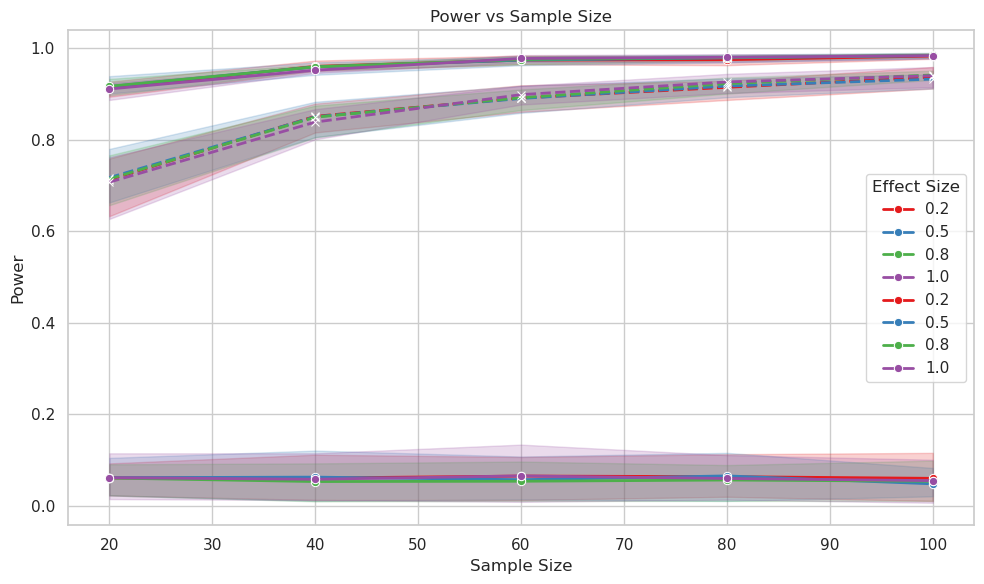

In [56]:
sns.set(style="whitegrid")
palette = sns.color_palette("Set1")

plt.figure(figsize=(10, 6))
sns.lineplot(data=df[df['effect_size'] > 0], x="sample_size", y="power_orig", hue="effect_size", palette=palette, marker="o", linewidth=2)
sns.lineplot(data=df[df['effect_size'] > 0], x="sample_size", y="power_standard", hue="effect_size", palette=palette, marker="o", linewidth=2)
sns.lineplot(data=df[df['effect_size'] > 0], x="sample_size", y="power_noised", hue="effect_size", palette=palette, marker="x", linestyle="--", linewidth=2, legend=False)
plt.title("Power vs Sample Size")
plt.ylabel("Power")
plt.xlabel("Sample Size")
plt.legend(title="Effect Size")
plt.tight_layout()
plt.show()

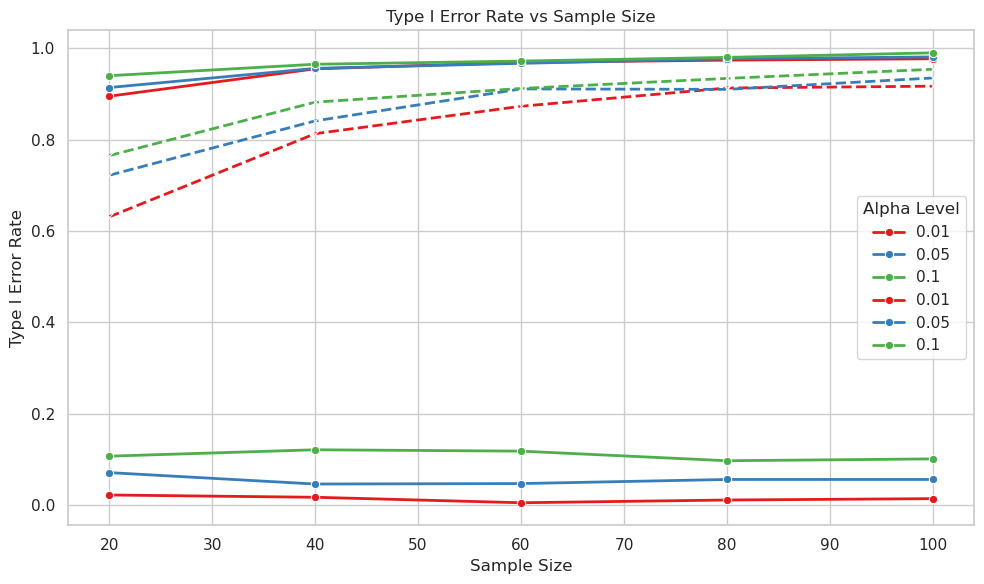

In [57]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df[df['effect_size'] == 0], x="sample_size", y="type_I_orig", hue="alpha", palette=palette, marker="o", linewidth=2)
sns.lineplot(data=df[df['effect_size'] == 0], x="sample_size", y="type_I_standard", hue="alpha", palette=palette, marker="o", linewidth=2)
sns.lineplot(data=df[df['effect_size'] == 0], x="sample_size", y="type_I_noised", hue="alpha", palette=palette, marker="x", linestyle="--", linewidth=2, legend=False)
plt.title("Type I Error Rate vs Sample Size")
plt.ylabel("Type I Error Rate")
plt.xlabel("Sample Size")
plt.legend(title="Alpha Level")
plt.tight_layout()
plt.show()



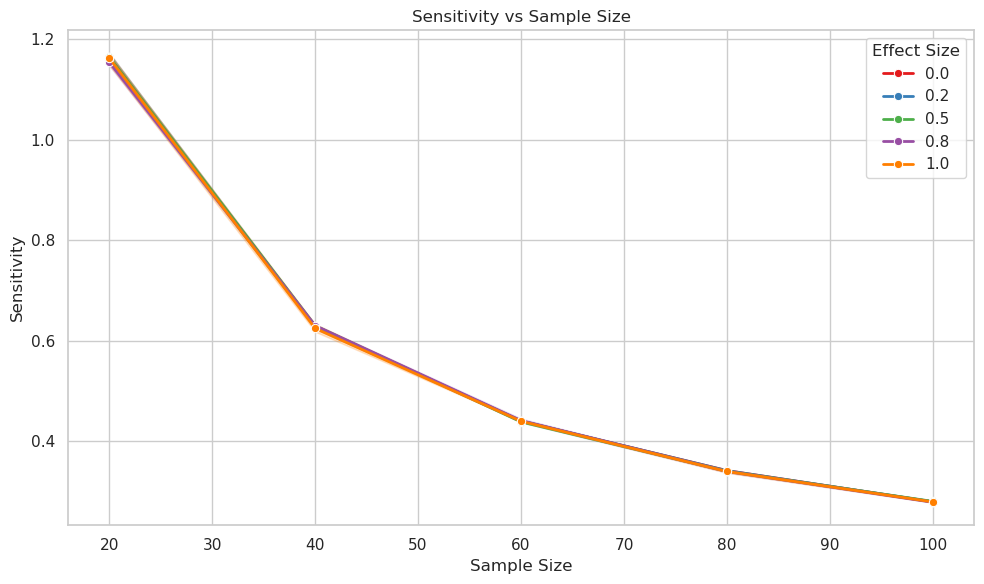

In [58]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="sample_size", y="sensitivity", hue="effect_size", palette=palette, marker="o", linewidth=2)
plt.title("Sensitivity vs Sample Size")
plt.ylabel("Sensitivity")
plt.xlabel("Sample Size")
plt.legend(title="Effect Size")
plt.tight_layout()
plt.show()


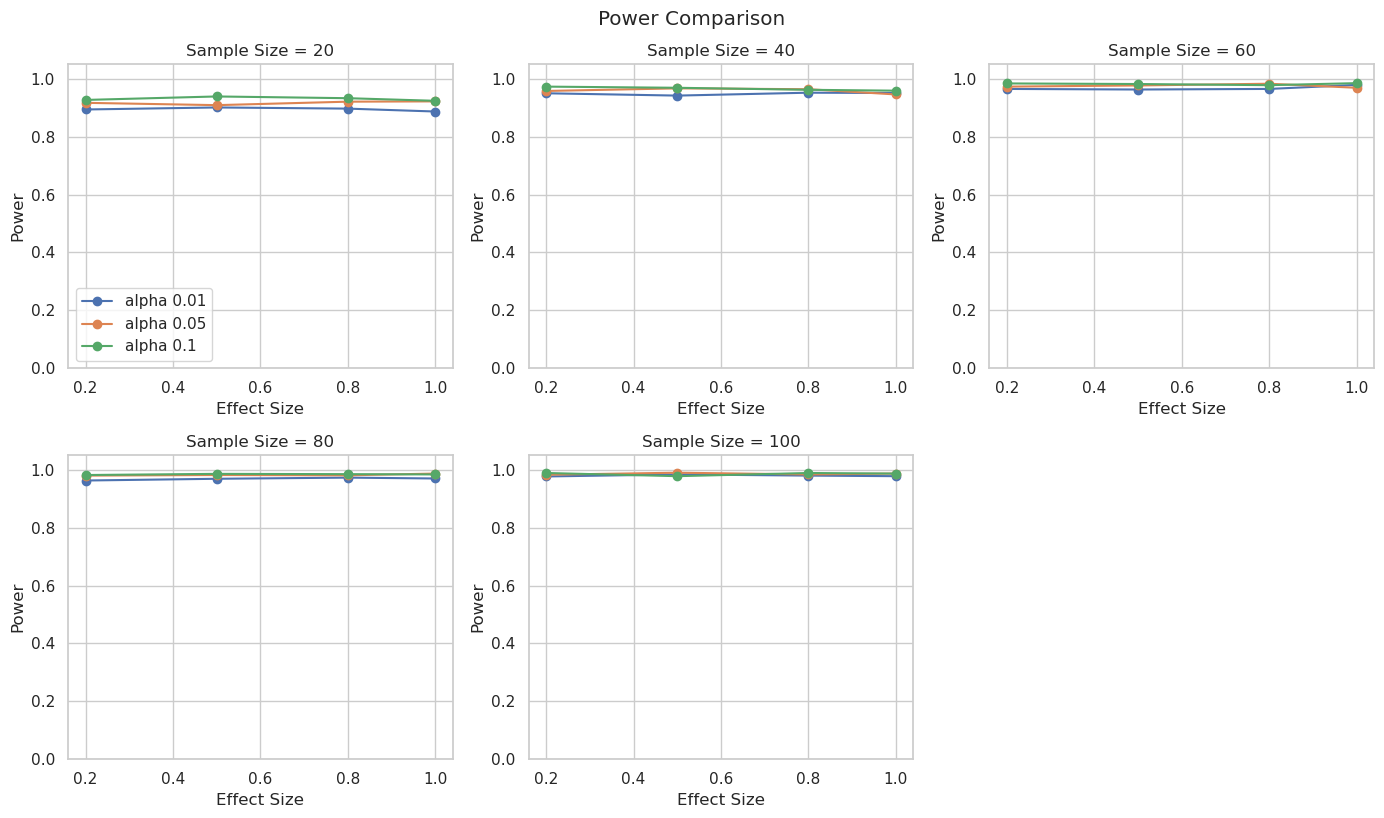

In [59]:

plt.figure(figsize=(14, 8))
alpha_ = [0.01, 0.05, 0.1]
for i, size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
    plt.plot(al1['effect_size'], al1['power_standard'], 'o-', label='alpha 0.01')
    plt.plot(al2['effect_size'], al2['power_standard'], 'o-', label='alpha 0.05')
    plt.plot(al3['effect_size'], al3['power_standard'], 'o-', label='alpha 0.1')
       
    plt.xlabel('Effect Size')
    plt.ylabel('Power')
    plt.title(f'Sample Size = {size}')
    plt.ylim(0, 1.05)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle(f'Power Comparison', y=1.02)
plt.show()




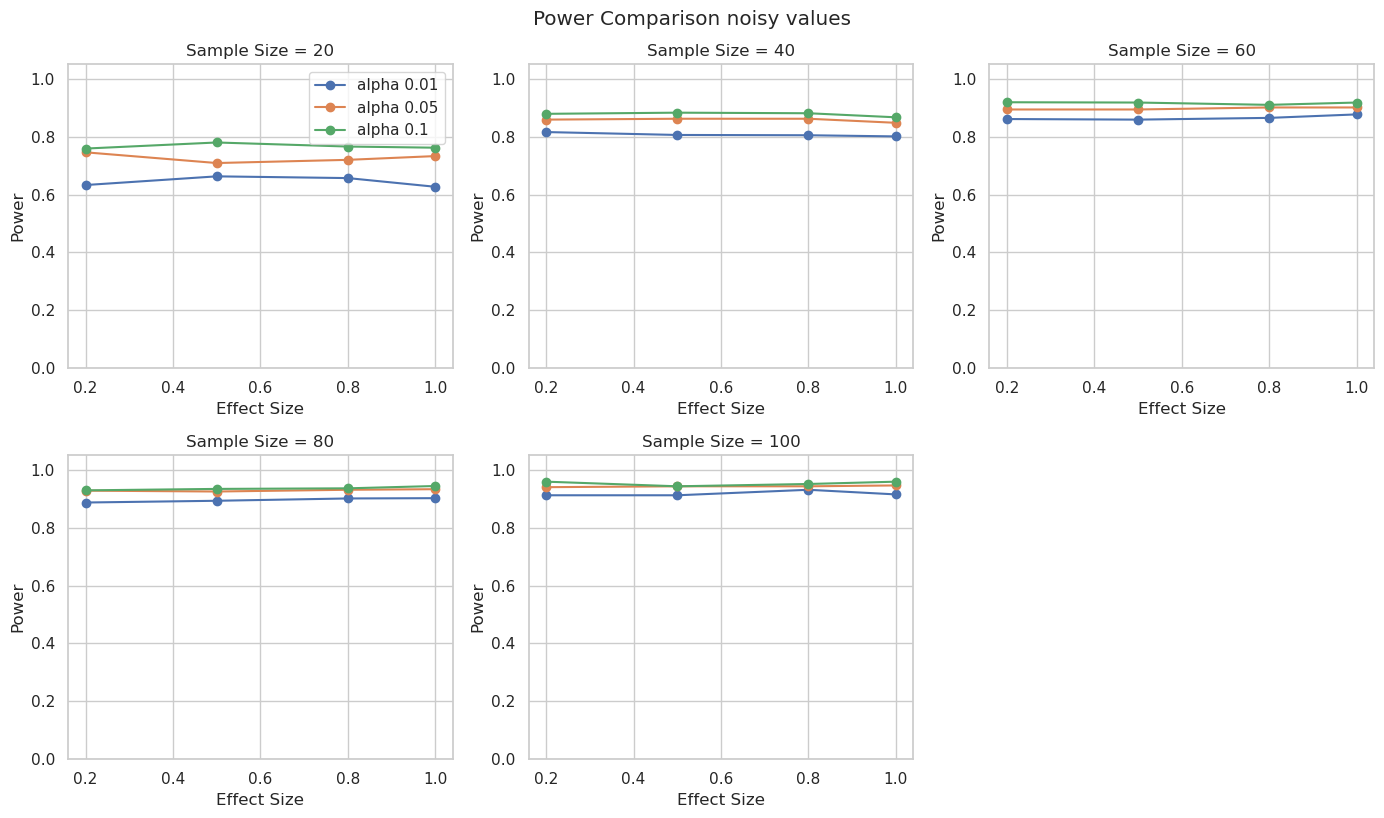

In [60]:
df = pd.DataFrame(results)

plt.figure(figsize=(14, 8))
alpha_ = [0.01, 0.05, 0.1]
for i, size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
    plt.plot(al1['effect_size'], al1['power_noised'], 'o-', label='alpha 0.01')
    plt.plot(al2['effect_size'], al2['power_noised'], 'o-', label='alpha 0.05')
    plt.plot(al3['effect_size'], al3['power_noised'], 'o-', label='alpha 0.1')
       
    plt.xlabel('Effect Size')
    plt.ylabel('Power')
    plt.title(f'Sample Size = {size}')
    plt.ylim(0, 1.05)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle(f'Power Comparison noisy values', y=1.02)
plt.show()




In [6]:

plt.figure(figsize=(10, 6))
plt.hist(p_n, bins=50, alpha=0.6, label='Null Hypothesis (True)', color='blue')
plt.hist(p_a, bins=50, alpha=0.6, label='Alternative Hypothesis (True)', color='red')
plt.axvline(alpha, color='black', linestyle='--', label=f'Significance Level (alpha = {alpha})')
plt.title('Distribution of P-values Under Null and Alternative Hypotheses')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'p_n' is not defined

<Figure size 1000x600 with 0 Axes>

In [213]:
def calc_sens(data):
    loo_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
    loo_stds = np.array([np.std(np.delete(data, i), ddof=1) for i in range(len(data))])
    mean_sensitivity = np.max(np.abs(loo_means - np.mean(data)))
    std_sensitivity = np.max(np.abs(loo_stds - np.std(data, ddof=1)))
    
    return mean_sensitivity, std_sensitivity

def add_noise(clean_data, pipeline_mean, pipeline_std):
    
    mean_sens, std_sens = calc_sens(clean_data)
    noisy_mean = pipeline_mean + np.random.laplace(loc=0, scale=mean_sens)
    noisy_std = pipeline_std + np.random.laplace(loc=0, scale=std_sens)
    noisy_std = max(noisy_std, 0.1)  
    
    return noisy_mean, noisy_std, mean_sens, std_sens